# Passwords

In [1]:
import itertools
import string
import time
import math
import hmac
import base64
import struct
import hashlib
from IPython.display import display
import pyotp
import qrcode

### Charsets

In [2]:
def gen_charsets():
    lower = "abcdefghijklmnopqrstuvwxyz"
    upper = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    special =  "!@#$%^&* .,"
    digit = "0123456789" 
    basic_charsets = [lower, upper, digit, special]
    charsets = [""]
    for to_add in basic_charsets:
        for i in range(len(charsets)):
            charsets.append(charsets[i] + to_add)
    charsets = sorted(charsets, key = lambda x:len(x))
    return charsets

def get_charset(pw):
    for cs in gen_charsets():
        if set(pw) <= set(cs):
            return cs
    return None


gen_charsets()

['',
 '0123456789',
 '!@#$%^&* .,',
 '0123456789!@#$%^&* .,',
 'abcdefghijklmnopqrstuvwxyz',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
 'abcdefghijklmnopqrstuvwxyz0123456789',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
 'abcdefghijklmnopqrstuvwxyz!@#$%^&* .,',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ!@#$%^&* .,',
 'abcdefghijklmnopqrstuvwxyz0123456789!@#$%^&* .,',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&* .,',
 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!@#$%^&* .,',
 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&* .,']

### Password strength 

In [5]:
def password_strength(pw):
    charset = get_charset(pw)
    num_iters =  len(charset)**len(pw)
    return num_iters, math.log10(num_iters)

password = "ash12"
iters, iters_log = password_strength(password)
print(f"Number of iterations={iters}\nLogarithm of iterations={iters_log}") 

Number of iterations=60466176
Logarithm of iterations=7.781512503836437


### Brute force attack

#### Plain password

In [6]:
def brute_force(password, charset):
    start_time = time.time()
    attempts = 0
    if charset == None:
        charset = get_charset(password)
    for length in range(1, len(password) + 1):
        for l in itertools.product(charset, repeat=length):
            attempts += 1
            password_guess = ''.join(l)
            if password_guess == password:
                end_time = time.time()
                elapsed = end_time - start_time
                print(f"Password cracked: {password_guess}")
                return elapsed, attempts

    return None, attempts

In [7]:
# Test with a short password
password = "abcdA"
print(password_strength(password))
seconds, tries = brute_force(password, charset = None)

print(f"⏱ Cracked in {seconds:.2f} seconds after {tries} attempts.")


(380204032, 8.580016718173995)
Password cracked: abcdA
⏱ Cracked in 3.03 seconds after 7601179 attempts.


#### Hashed password

In [9]:
def SHA1(password):
    H = hashlib.sha1()
    bpw_bytes = password.encode()
    H.update(bpw_bytes)
    return H.digest().hex().upper()

pw_hash = SHA1('password')
print(pw_hash)
SHA1('passwore')

5BAA61E4C9B93F3F0682250B6CF8331B7EE68FD8


'C406539B6E55106CA1917673CD49D13683605B7E'

In [11]:
start_time = time.time() 
charset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&* .'
tries = 0
for length in range(1, 5):
    print(f"passwords of length={length}")
    for l in itertools.product(charset, repeat=length):
        password_guess = ''.join(l)
        tries += 1
#         print(password_guess)
        if pw_hash == SHA1(password_guess):
            print(f"password={password_guess}")
            break
seconds = time.time() - start_time
print(f"⏱ Cracked in {seconds:.2f} seconds after {tries} attempts.")

passwords of length=1
passwords of length=2
passwords of length=3
passwords of length=4
⏱ Cracked in 84.78 seconds after 27252360 attempts.


#### Database preprocessing
Database format: **hash** of the password , **frequency** in databreaches <br />
    `000000005AD76BD555C1D6D771DE417A4B87E4B4, 4` <br />
    `00000000A8DAE4228F821FB418F59826079BF368, 3` <br />
...

In [ ]:
# with open('pwnd.csv') as f:
#     most_frequent = {}
#     for _ in range(400000000):
#         line = f.readline().split(',') 
#         pw_hash, freq = line 
#         if int(freq) > 10000:
#             most_frequent[pw_hash] = freq
#     print(len(most_frequent))
#     with open('most frequent.csv', 'w') as fw:
#         for pw_hash, freq in most_frequent.items():
#             fw.write(f"{pw_hash},{freq}")
        

In [ ]:
# charset = 'abcdefghijklmnopqrstuvwxyz' 
# with open('most frequent.csv', 'r') as f:
#     pw_hashes = {tuple(line.split(',')) for line in f.readlines()}
# #     print(pw_hashes)
#     for length in range(1, 6):
#         print(f"{length}")
#         for l in itertools.product(charset, repeat=length):
#             password_guess = ''.join(l)
# #             print(password_guess)
#             pw_guess_hash = SHA1(password_guess)
#             if password_guess in pw_hashes:
#                 print(password_guess, pw_guess_hash)



### KeePass attack


In [12]:
from pykeepass import PyKeePass

# https://github.com/scubajorgen/KeepassDecrypt
def test_password(database_path, password):
    try:
        PyKeePass(database_path, password)
        return True
    except:
        return False
    
kp = PyKeePass('Database.kdbx', password='aaa')

for password in itertools.product('cab', repeat=3):
    password = ''.join(password)
    print(password)
    if test_password('Database.kdbx', password) == True:
        print(password)
        break


ccc
cca
ccb
cac
caa
cab
cbc
cba
cbb
acc
aca
acb
aac
aaa
aaa


# HOTP

### Secret


 Scan this QR code in your Authenticator app (e.g., Google Authenticator):


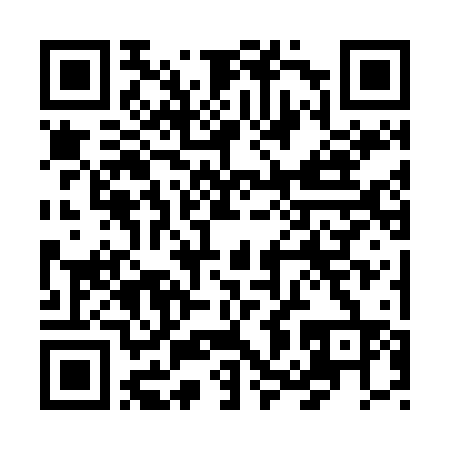

In [ ]:
# Generate a unique TOTP secret key for the user
secret = pyotp.random_base32()
totp = pyotp.TOTP(secret)

# Generate a provisioning URI for use with Authenticator apps
issuer_name = "PV080"
user_email = "student@muni.cz"
uri = totp.provisioning_uri(name=user_email, issuer_name=issuer_name)

# Display the QR code for the user to scan
print(" Scan this QR code in your Authenticator app (e.g., Google Authenticator):")
qr_img = qrcode.make(uri)
display(qr_img)

# Prompt user to enter their 2FA code
user_code = input(" Enter the 6-digit code from your Authenticator app: ")

# Verify the code
if totp.verify(user_code):
    print("✅ Success! Your identity has been verified.")
else:
    print("❌ Invalid code. Please try again.")

### HMAC


In [4]:
def get_hotp(key, counter, n_digits):
    """
    Computes HOTP value according to RFC 4226 https://www.ietf.org/rfc/rfc4226.txt
    @param key: The pre-shared key in a form of base32 string (arbitrary length)
    @param counter: The counter used to compute the one-time password
    @param n_digits: How many digits should the resulting decimal code have
    """
    # Decodes the secret key from base32 to bytes
    key = base64.b32decode(key, casefold=True)

    # Encodes the counter into bytes
    c = counter.to_bytes(8, byteorder="big", signed=False)

    # Computes HMAC(key, counter) with SHA-1 as the underlying func
    mac = hmac.new(key, c, "sha1").digest()

    # Computes 4 most significant bits of mac, written in decimal
    i = mac[-1] & 0x0F

    # Takes 31 most significant bits out of 4 bytes in MAC that start at offset i
    # Taking 31 bits effectively gets rid of the sign bit, while the integer still fits 4 bytes.
    # This is desired to remove the ambiguity caused by different implementations on different platforms
    truncated = int.from_bytes(
        mac[i: i + 4], byteorder="big", signed=False) & 0x7FFFFFFF

    # Modulo the desired number of digits
    return truncated % (10 ** n_digits)

token = get_hotp(secret.lower(), int(time.time()) // 30, n_digits=6)
print(str(token).zfill(6))

684394
